In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
## set train, validation, and test paths
train_path = '../input/datasetfinal/dataset70-10-20/train/Vegetables'
validation_path = '../input/datasetfinal/dataset70-10-20/val/Vegetables'
test_path = '../input/datasetfinal/dataset70-10-20/test/Vegetables'

In [3]:
veg_classes=[]
for root, subdirectories, files in os.walk(train_path):
    for subdirectory in subdirectories:
        veg_classes.append(subdirectory)
print(len(veg_classes))

22


In [4]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224, 224), classes = veg_classes, batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224, 224), classes = veg_classes, batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224, 224), classes = veg_classes, batch_size = 10)

Found 903 images belonging to 22 classes.
Found 122 images belonging to 22 classes.
Found 281 images belonging to 22 classes.


## Data Augmentation

In [5]:
## Augmentation datagenerator
train_datagen_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True)

## train generator
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## test generator, required for prediction
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

## validation generator
val_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 903 images belonging to 22 classes.
Found 281 images belonging to 22 classes.
Found 122 images belonging to 22 classes.


In [6]:
## set steps per epoch for train
train_filenames = train_generator_aug.filenames
steps_train = len(train_filenames)/train_generator_aug.batch_size

## set steps per epoch for validation
val_filenames = val_generator.filenames
steps_val = len(val_filenames)/val_generator.batch_size

## test
filenames_test = test_generator.filenames
nb_samples_test= len(filenames_test)
true_classes = test_generator.classes
target_names = veg_classes

## Mobilenet with Augmentation and DropOut

In [7]:
model_mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 

model_mobilenet.summary()
model_mobilenet.trainable = False

2022-01-05 16:18:32.305754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:18:32.413665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:18:32.414896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:18:32.416686: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [8]:
veg_mobilenet = Sequential()
veg_mobilenet.add(model_mobilenet)
veg_mobilenet.add(GlobalAveragePooling2D())
veg_mobilenet.add(Dropout(0.4))
veg_mobilenet.add(Dense(22, activation='softmax'))
veg_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 22)                28182     
Total params: 2,286,166
Trainable params: 28,182
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
## compile model
veg_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

# Callbacks
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 6, verbose=1)
mc = ModelCheckpoint("./veg_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
cb=[es, mc]

## fit model
fit_generator = veg_mobilenet.fit(train_generator_aug,
                                  steps_per_epoch=steps_train,
                                  epochs=100,
                                  validation_data=val_generator,
                                  validation_steps=steps_val,
                                  verbose=1,
                                  callbacks=cb)

2022-01-05 16:18:38.488367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-05 16:18:42.934590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 27s 497ms/step - loss: 2.6195 - acc: 0.2724 - val_loss: 1.3024 - val_acc: 0.6230
Epoch 2/100
36/36 [==============================] - 13s 366ms/step - loss: 1.1061 - acc: 0.6656 - val_loss: 0.7530 - val_acc: 0.7787
Epoch 3/100
36/36 [==============================] - 13s 352ms/step - loss: 0.7613 - acc: 0.7608 - val_loss: 0.6019 - val_acc: 0.8115
Epoch 4/100
36/36 [==============================] - 13s 371ms/step - loss: 0.5527 - acc: 0.8405 - val_loss: 0.4612 - val_acc: 0.8689
Epoch 5/100
36/36 [==============================] - 13s 347ms/step - loss: 0.4749 - acc: 0.8416 - val_loss: 0.4011 - val_acc: 0.8770
Epoch 6/100
36/36 [==============================] - 13s 348ms/step - loss: 0.3548 - acc: 0.9003 - val_loss: 0.3713 - val_acc: 0.8607
Epoch 7/100
36/36 [==============================] - 13s 365ms/step - loss: 0.3309 - acc: 0.8992 - val_loss: 0.3264 - val_acc: 0.8852
Epoch 8/100
36/36 [==============================] - 13s 362ms/step - loss

In [10]:
veg_mobilenet.save('veg_mobilenet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [11]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(veg_mobilenet)
tflite_model = converter.convert()

# Save the model.
with open('veg_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

2022-01-05 16:41:35.837023: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-01-05 16:41:56.967973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:41:56.968714: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-05 16:41:56.968866: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-05 16:41:56.969542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

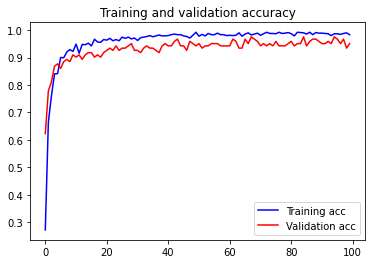

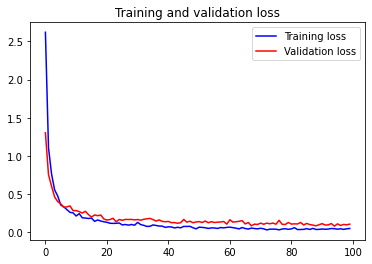

In [12]:
acc = fit_generator.history['acc']
val_acc = fit_generator.history['val_acc']
loss = fit_generator.history['loss']
val_loss = fit_generator.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Predict

In [13]:
vegs_pred= veg_mobilenet.predict(test_generator, steps = nb_samples_test, verbose=2)
vegs_pred= vegs_pred.argmax(axis=1)

281/281 - 4s


### Classification Report

In [14]:
print(classification_report(true_classes, vegs_pred, target_names=target_names))

                    precision    recall  f1-score   support

              Leek       0.89      1.00      0.94         8
      Solid-Potato       1.00      0.82      0.90        11
            Ginger       0.91      0.91      0.91        11
          Zucchini       0.94      1.00      0.97        17
   Red-Bell-Pepper       1.00      1.00      1.00         9
      Sweet-Potato       1.00      1.00      1.00        19
       Beef-Tomato       1.00      0.75      0.86        12
     Floury-Potato       1.00      0.78      0.88         9
       Vine-Tomato       0.91      1.00      0.95        10
    Regular-Tomato       1.00      0.67      0.80         9
Yellow-Bell-Pepper       0.92      1.00      0.96        11
      Yellow-Onion       1.00      1.00      1.00        11
          Red-Beet       1.00      0.85      0.92        13
         Asparagus       1.00      1.00      1.00         8
         Aubergine       1.00      1.00      1.00        15
           Cabbage       1.00      1.00